# Baseline model

## Load data

In [1]:
import pickle_toolbox as pt

In [2]:
label_source = pt.pickle_load("data/pmid_label_new.pickle")
title_source = pt.pickle_load("data/embedded_title_words_new.pickle")
abstract_source = pt.pickle_load("data/embedded_abstract_words_new.pickle")

The content of the pickled file is ready!
The content of the pickled file is ready!
The content of the pickled file is ready!


## Show length of each sentence 

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

In [4]:
abstract_len = [len(abstract) for abstract in abstract_source.values()]
title_len = [len(title) for title in title_source.values()]
sen_len = abstract_len + title_len
print("logest texture has words: {}".format(max(sen_len)))

MAX_SEQUENCE_LENGTH = max(sen_len)

logest texture has words: 570


Text(0.5, 1.0, 'Distribution of words #')

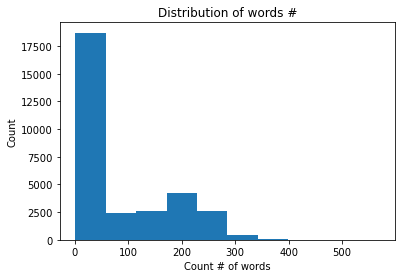

In [5]:
count = np.array(sen_len)
plt.hist(count);
plt.ylabel("Count")
plt.xlabel("Count # of words")
plt.title("Distribution of words #")

## Split train and test dataset

### split dataset

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
TRAIN_SIZE = 0.95
pmids = [pmid for pmid in abstract_source.keys()]  # only a part of abstract obtained, use their pmids
labels = [label_source[pmid] for pmid in pmids]
train_pmids, test_pmids = train_test_split(pmids, test_size=1-TRAIN_SIZE, shuffle=True, stratify=labels,
                                         random_state=7) # Splits Dataset into Train/Test dataset

In [8]:
print("Total sample size: {}".format(len(pmids)))
print("Size of train set: {}".format(len(train_pmids)))
print("Size of test set: {}".format(len(test_pmids)))

Total sample size: 15391
Size of train set: 14621
Size of test set: 770


### check label distribution

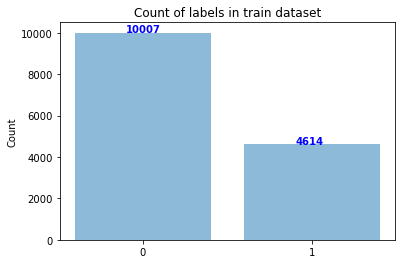

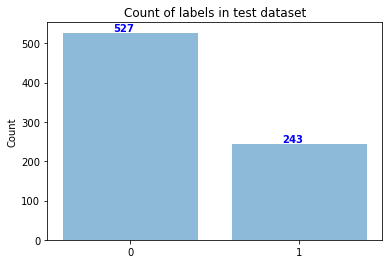

In [9]:
train_label = [label_source[pmid] for pmid in train_pmids]
test_label = [label_source[pmid] for pmid in test_pmids]
count_train = [train_label.count(0), train_label.count(1)]
count_test = [test_label.count(0), test_label.count(1)]
label_items = [0, 1]
# Train dataset
plt.figure(0)
plt.bar(label_items, count_train, align='center', alpha=0.5)
plt.xticks(label_items)
plt.ylabel('Count')
plt.title('Count of labels in train dataset')
for x, y in enumerate(count_train):
    plt.text(x-0.1, y + 10, str(y), color='blue', fontweight='bold')
    
# Test dataset
plt.figure(1)
plt.bar(label_items, count_test, align='center', alpha=0.5)
plt.xticks(label_items)
plt.ylabel('Count')
plt.title('Count of labels in test dataset')
for x, y in enumerate(count_test):
    plt.text(x-0.1, y + 5, str(y), color='blue', fontweight='bold')

### Caculate the weight of classes

In [31]:
weight_for_0 = (1 / count_train[0]) * (sum(count_train) / 2.0)
weight_for_1 = (1 / count_train[1]) * (sum(count_train)/ 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 0.73
Weight for class 1: 1.58


# Baseline model: average input 
model

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Average, Input, Dense, Activation
tf.enable_eager_execution() 
import numpy as np

### Check shape of input word vector

In [11]:
for pmid in train_pmids:
    abstract = abstract_source[pmid]
    print("Length of sentence: {}".format(len(abstract)))
    print("Shape of one word vector: {}".format(abstract[1].shape))
    break

Length of sentence: 79
Shape of one word vector: (200,)


### Format train data and test data

In [12]:
#avg = Average()(abstract)
#print(avg)
    
def average_dataset(abstractset, titleset, pmids, max_len=MAX_SEQUENCE_LENGTH):
    avg_list = []
    tn = 1
    an = 1
    for pmid in pmids:
        try:
            abstract = abstractset[pmid]
        except Exception as e:
            print("{}. Not in abstract: {}".format(an, e))
            abstract = []
            an += 1
        try:
            title = titleset[pmid]
        except Exception as e:
            print("{}. Not in title: {}".format(tn, e))
            title = []
            tn += 1
        tmp = abstract + title
        avg_list.append(Average()(abstract + title))
        sample_size = len(avg_list)
    vector_size = avg_list[1].shape[0]
    avge_output = np.zeros((sample_size, vector_size))
    for i in range(sample_size):
        avge_output[i,:] = avg_list[i]
    return avge_output

#avg_list = average_dataset(abstract_source, title_source, train_pmids)
#average_dataset(abstract_source, title_source, train_pmids)

traindata = average_dataset(abstract_source, title_source, train_pmids)
testdata = average_dataset(abstract_source, title_source, test_pmids)
    


1. Not in title: '30996850'
2. Not in title: '34445333'
3. Not in title: '27974549'
4. Not in title: '34235180'
5. Not in title: '34196900'
6. Not in title: '33732287'
7. Not in title: '28744144'
8. Not in title: '33910496'
9. Not in title: '33670055'
10. Not in title: '33553733'
11. Not in title: '29755871'
12. Not in title: '33941849'
13. Not in title: '34172079'
14. Not in title: '34513534'
15. Not in title: '34276781'
16. Not in title: '33858678'
17. Not in title: '34771991'
18. Not in title: '34541275'
19. Not in title: '34247610'
20. Not in title: '31920960'
21. Not in title: '34198652'
22. Not in title: '33454955'
23. Not in title: '33552952'
24. Not in title: '33875564'
25. Not in title: '34350294'
26. Not in title: '34160841'
27. Not in title: '33809179'
28. Not in title: '32981916'
29. Not in title: '33403015'
30. Not in title: '30186769'
31. Not in title: '33891299'
32. Not in title: '33898318'
33. Not in title: '32014905'
34. Not in title: '34251444'
35. Not in title: '3435

###  Weighted baseline model define

In [13]:
# Encode labels for train dataset
train_labels_raw = [label_source[pmid] for pmid in train_pmids]
#train_labels = tf.one_hot(train_labels_raw, 2)  # one hot encode Y labels
train_labels = train_labels_raw
#train_labels.shape
#print(train_labels)

In [95]:
BATCH_SIZE = 128
def baseline_model(input_shape):
    input_data = Input(shape=input_shape, dtype="float32", name="input_layer")
    #x = Dense(units=4, name="full_connection_layer_1", activation='tanh')(input_data)
    #x = Dense(units=4, name="full_connection_layer_2")(input_data)
    x = Dense(units=1, name="full_connection_layer_2")(input_data)
    x = Activation("sigmoid", name="activation_layer")(x)
    model = Model(inputs=input_data, outputs=x)
    return model
    
model = baseline_model(traindata.shape[1])
model.summary()

tf.compat.v1.random.set_random_seed(111)
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), metrics=['binary_accuracy', 'Precision', "Recall", "AUC"])

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 200)]             0         
_________________________________________________________________
full_connection_layer_2 (Den (None, 1)                 201       
_________________________________________________________________
activation_layer (Activation (None, 1)                 0         
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


#### Training

In [51]:
history_baseline_1 = model.fit(traindata, train_labels, epochs = 500, batch_size = BATCH_SIZE, shuffle=True, class_weight=class_weight)

Epoch 1/500
14621/14621 [==============================] - 0s 34us/sample - loss: 0.6260 - binary_accuracy: 0.6404 - precision_10: 0.4553 - recall_10: 0.7113 - auc_10: 0.7139
Epoch 2/500
14621/14621 [==============================] - 0s 20us/sample - loss: 0.5896 - binary_accuracy: 0.6685 - precision_10: 0.4836 - recall_10: 0.7447 - auc_10: 0.7501
Epoch 3/500
14621/14621 [==============================] - 0s 20us/sample - loss: 0.5808 - binary_accuracy: 0.6724 - precision_10: 0.4876 - recall_10: 0.7529 - auc_10: 0.7582
Epoch 4/500
14621/14621 [==============================] - 0s 20us/sample - loss: 0.5743 - binary_accuracy: 0.6803 - precision_10: 0.4957 - recall_10: 0.7436 - auc_10: 0.7652
Epoch 5/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5697 - binary_accuracy: 0.6832 - precision_10: 0.4987 - recall_10: 0.7568 - auc_10: 0.7703
Epoch 6/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5666 - binary_accuracy: 0.6877 - precisio

14621/14621 [==============================] - 0s 20us/sample - loss: 0.5451 - binary_accuracy: 0.7060 - precision_10: 0.5236 - recall_10: 0.7575 - auc_10: 0.7940
Epoch 46/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5454 - binary_accuracy: 0.7069 - precision_10: 0.5246 - recall_10: 0.7566 - auc_10: 0.7937
Epoch 47/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5449 - binary_accuracy: 0.7085 - precision_10: 0.5265 - recall_10: 0.7583 - auc_10: 0.7944
Epoch 48/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5444 - binary_accuracy: 0.7052 - precision_10: 0.5225 - recall_10: 0.7661 - auc_10: 0.7945
Epoch 49/500
14621/14621 [==============================] - 0s 20us/sample - loss: 0.5433 - binary_accuracy: 0.7073 - precision_10: 0.5251 - recall_10: 0.7607 - auc_10: 0.7955
Epoch 50/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5436 - binary_accuracy: 0.7080 - precision_10: 0

14621/14621 [==============================] - 0s 18us/sample - loss: 0.5448 - binary_accuracy: 0.7052 - precision_10: 0.5227 - recall_10: 0.7573 - auc_10: 0.7944
Epoch 90/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5418 - binary_accuracy: 0.7091 - precision_10: 0.5273 - recall_10: 0.7568 - auc_10: 0.7967
Epoch 91/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5438 - binary_accuracy: 0.7069 - precision_10: 0.5246 - recall_10: 0.7592 - auc_10: 0.7953
Epoch 92/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5428 - binary_accuracy: 0.7081 - precision_10: 0.5261 - recall_10: 0.7566 - auc_10: 0.7962
Epoch 93/500
14621/14621 [==============================] - 0s 18us/sample - loss: 0.5420 - binary_accuracy: 0.7105 - precision_10: 0.5285 - recall_10: 0.7657 - auc_10: 0.7967
Epoch 94/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5428 - binary_accuracy: 0.7106 - precision_10: 0

14621/14621 [==============================] - 0s 19us/sample - loss: 0.5425 - binary_accuracy: 0.7099 - precision_10: 0.5279 - recall_10: 0.7618 - auc_10: 0.7964
Epoch 135/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5423 - binary_accuracy: 0.7109 - precision_10: 0.5291 - recall_10: 0.7614 - auc_10: 0.7965
Epoch 136/500
14621/14621 [==============================] - 0s 18us/sample - loss: 0.5407 - binary_accuracy: 0.7119 - precision_10: 0.5303 - recall_10: 0.7594 - auc_10: 0.7982
Epoch 137/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5404 - binary_accuracy: 0.7109 - precision_10: 0.5290 - recall_10: 0.7638 - auc_10: 0.7986
Epoch 138/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5426 - binary_accuracy: 0.7119 - precision_10: 0.5306 - recall_10: 0.7529 - auc_10: 0.79650s - loss: 0.5425 - binary_accuracy: 0.7164 - precision_10: 0.5326 - recall_10: 0.7329 - auc_10: 0.
Epoch 139/500
14621/14621 [===

14621/14621 [==============================] - 0s 18us/sample - loss: 0.5406 - binary_accuracy: 0.7125 - precision_10: 0.5308 - recall_10: 0.7664 - auc_10: 0.7982
Epoch 180/500
14621/14621 [==============================] - 0s 18us/sample - loss: 0.5410 - binary_accuracy: 0.7108 - precision_10: 0.5293 - recall_10: 0.7555 - auc_10: 0.7976
Epoch 181/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5422 - binary_accuracy: 0.7119 - precision_10: 0.5303 - recall_10: 0.7627 - auc_10: 0.7968
Epoch 182/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5427 - binary_accuracy: 0.7117 - precision_10: 0.5300 - recall_10: 0.7642 - auc_10: 0.7966
Epoch 183/500
14621/14621 [==============================] - 0s 18us/sample - loss: 0.5409 - binary_accuracy: 0.7129 - precision_10: 0.5319 - recall_10: 0.7544 - auc_10: 0.7979
Epoch 184/500
14621/14621 [==============================] - 0s 18us/sample - loss: 0.5432 - binary_accuracy: 0.7110 - precision_

14621/14621 [==============================] - 0s 18us/sample - loss: 0.5421 - binary_accuracy: 0.7140 - precision_10: 0.5328 - recall_10: 0.7594 - auc_10: 0.7971
Epoch 225/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5422 - binary_accuracy: 0.7113 - precision_10: 0.5296 - recall_10: 0.7609 - auc_10: 0.7968
Epoch 226/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5442 - binary_accuracy: 0.7098 - precision_10: 0.5280 - recall_10: 0.7581 - auc_10: 0.7949
Epoch 227/500
14621/14621 [==============================] - 0s 18us/sample - loss: 0.5414 - binary_accuracy: 0.7113 - precision_10: 0.5297 - recall_10: 0.7607 - auc_10: 0.7974
Epoch 228/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5414 - binary_accuracy: 0.7125 - precision_10: 0.5309 - recall_10: 0.7635 - auc_10: 0.7976
Epoch 229/500
14621/14621 [==============================] - 0s 18us/sample - loss: 0.5397 - binary_accuracy: 0.7132 - precision_

14621/14621 [==============================] - 0s 18us/sample - loss: 0.5406 - binary_accuracy: 0.7130 - precision_10: 0.5317 - recall_10: 0.7594 - auc_10: 0.7984
Epoch 271/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5395 - binary_accuracy: 0.7121 - precision_10: 0.5305 - recall_10: 0.7625 - auc_10: 0.7993
Epoch 272/500
14621/14621 [==============================] - 0s 18us/sample - loss: 0.5408 - binary_accuracy: 0.7125 - precision_10: 0.5309 - recall_10: 0.7638 - auc_10: 0.7982
Epoch 273/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5421 - binary_accuracy: 0.7110 - precision_10: 0.5295 - recall_10: 0.7575 - auc_10: 0.7972
Epoch 274/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5416 - binary_accuracy: 0.7097 - precision_10: 0.5277 - recall_10: 0.7644 - auc_10: 0.7972
Epoch 275/500
14621/14621 [==============================] - 0s 18us/sample - loss: 0.5401 - binary_accuracy: 0.7131 - precision_

14621/14621 [==============================] - 0s 18us/sample - loss: 0.5415 - binary_accuracy: 0.7125 - precision_10: 0.5312 - recall_10: 0.7588 - auc_10: 0.7976
Epoch 317/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5407 - binary_accuracy: 0.7139 - precision_10: 0.5327 - recall_10: 0.7614 - auc_10: 0.7982
Epoch 318/500
14621/14621 [==============================] - 0s 18us/sample - loss: 0.5397 - binary_accuracy: 0.7160 - precision_10: 0.5352 - recall_10: 0.7599 - auc_10: 0.7993
Epoch 319/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5412 - binary_accuracy: 0.7123 - precision_10: 0.5309 - recall_10: 0.7570 - auc_10: 0.7979
Epoch 320/500
14621/14621 [==============================] - 0s 18us/sample - loss: 0.5397 - binary_accuracy: 0.7127 - precision_10: 0.5314 - recall_10: 0.7570 - auc_10: 0.7993
Epoch 321/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5411 - binary_accuracy: 0.7119 - precision_

14621/14621 [==============================] - 0s 19us/sample - loss: 0.5414 - binary_accuracy: 0.7132 - precision_10: 0.5320 - recall_10: 0.7592 - auc_10: 0.7976
Epoch 362/500
14621/14621 [==============================] - 0s 18us/sample - loss: 0.5392 - binary_accuracy: 0.7154 - precision_10: 0.5343 - recall_10: 0.7644 - auc_10: 0.7996
Epoch 363/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5399 - binary_accuracy: 0.7119 - precision_10: 0.5302 - recall_10: 0.7633 - auc_10: 0.7989
Epoch 364/500
14621/14621 [==============================] - 0s 18us/sample - loss: 0.5402 - binary_accuracy: 0.7128 - precision_10: 0.5313 - recall_10: 0.7635 - auc_10: 0.7986
Epoch 365/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5416 - binary_accuracy: 0.7119 - precision_10: 0.5306 - recall_10: 0.7531 - auc_10: 0.7978
Epoch 366/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5407 - binary_accuracy: 0.7110 - precision_

14621/14621 [==============================] - 0s 18us/sample - loss: 0.5459 - binary_accuracy: 0.7124 - precision_10: 0.5311 - recall_10: 0.7564 - auc_10: 0.7944
Epoch 407/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5395 - binary_accuracy: 0.7121 - precision_10: 0.5306 - recall_10: 0.7614 - auc_10: 0.7994
Epoch 408/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5404 - binary_accuracy: 0.7137 - precision_10: 0.5323 - recall_10: 0.7638 - auc_10: 0.7985
Epoch 409/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5402 - binary_accuracy: 0.7125 - precision_10: 0.5311 - recall_10: 0.7599 - auc_10: 0.7985
Epoch 410/500
14621/14621 [==============================] - 0s 18us/sample - loss: 0.5402 - binary_accuracy: 0.7145 - precision_10: 0.5334 - recall_10: 0.7605 - auc_10: 0.7989
Epoch 411/500
14621/14621 [==============================] - 0s 18us/sample - loss: 0.5401 - binary_accuracy: 0.7124 - precision_

14621/14621 [==============================] - 0s 18us/sample - loss: 0.5400 - binary_accuracy: 0.7114 - precision_10: 0.5297 - recall_10: 0.7612 - auc_10: 0.7988
Epoch 452/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5406 - binary_accuracy: 0.7114 - precision_10: 0.5297 - recall_10: 0.7633 - auc_10: 0.7982
Epoch 453/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5397 - binary_accuracy: 0.7141 - precision_10: 0.5331 - recall_10: 0.7577 - auc_10: 0.7992
Epoch 454/500
14621/14621 [==============================] - 0s 18us/sample - loss: 0.5400 - binary_accuracy: 0.7094 - precision_10: 0.5277 - recall_10: 0.7534 - auc_10: 0.7989
Epoch 455/500
14621/14621 [==============================] - 0s 18us/sample - loss: 0.5407 - binary_accuracy: 0.7121 - precision_10: 0.5309 - recall_10: 0.7551 - auc_10: 0.7982
Epoch 456/500
14621/14621 [==============================] - 0s 19us/sample - loss: 0.5399 - binary_accuracy: 0.7125 - precision_

14621/14621 [==============================] - 0s 21us/sample - loss: 0.5407 - binary_accuracy: 0.7131 - precision_10: 0.5317 - recall_10: 0.7607 - auc_10: 0.7981
Epoch 498/500
14621/14621 [==============================] - 0s 20us/sample - loss: 0.5399 - binary_accuracy: 0.7140 - precision_10: 0.5328 - recall_10: 0.7594 - auc_10: 0.7990
Epoch 499/500
14621/14621 [==============================] - 0s 20us/sample - loss: 0.5413 - binary_accuracy: 0.7119 - precision_10: 0.5305 - recall_10: 0.7586 - auc_10: 0.7978
Epoch 500/500
14621/14621 [==============================] - 0s 21us/sample - loss: 0.5415 - binary_accuracy: 0.7097 - precision_10: 0.5279 - recall_10: 0.7599 - auc_10: 0.7978


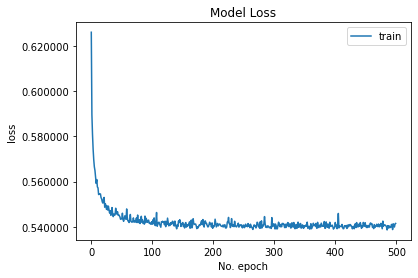

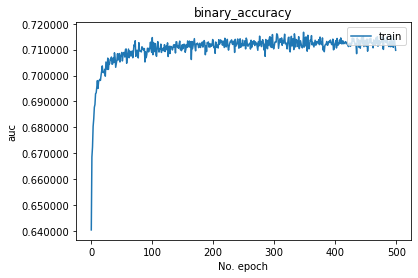

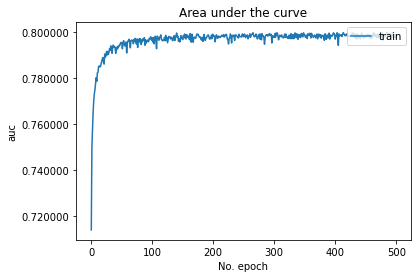

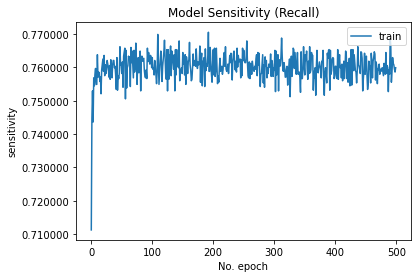

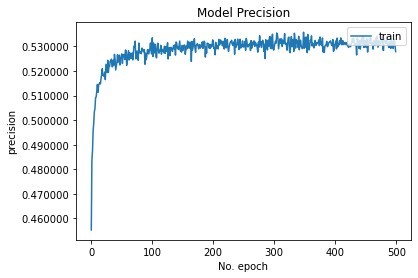

In [52]:
plt.figure(1)
plt.plot(history_baseline_1.history['loss'], label='Loss (training data)')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.6f'))
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(['train'], loc='upper right')

plt.figure(2)
acc_name = [key for key in history_baseline_1.history.keys() if "acc" in key][0]
plt.plot(history_baseline_1.history[acc_name], label='acc (training data)')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.6f'))
plt.title('binary_accuracy')

plt.ylabel('auc')
plt.xlabel('No. epoch')
plt.legend(['train'], loc='upper right')
plt.figure(3)
auc_name = [key for key in history_baseline_1.history.keys() if "auc" in key][0]
plt.plot(history_baseline_1.history[auc_name], label='auc (training data)')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.6f'))
plt.title('Area under the curve')

plt.ylabel('auc')
plt.xlabel('No. epoch')
plt.legend(['train'], loc='upper right')

plt.figure(4)
recall_name = [key for key in history_baseline_1.history.keys() if "recall" in key][0]
plt.plot(history_baseline_1.history[recall_name], label='Accuracy (training data)')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.6f'))
plt.title('Model Sensitivity (Recall)')
plt.ylabel('sensitivity')
plt.xlabel('No. epoch')
plt.legend(['train'], loc='upper right')

plt.figure(5)
recall_name = [key for key in history_baseline_1.history.keys() if "precision" in key][0]
plt.plot(history_baseline_1.history[recall_name], label='Precision (training data)')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.6f'))
plt.title('Model Precision')
plt.ylabel('precision')
plt.xlabel('No. epoch')
plt.legend(['train'], loc='upper right')

#### Validation

In [53]:
tf.compat.v1.random.set_random_seed(111)
test_labels_raw = [label_source[pmid] for pmid in test_pmids]
#test_labels = tf.one_hot(test_labels_raw, 1)  # one hot encode Y labels
test_labels = test_labels_raw
#test_labels.shape
test = model.evaluate(testdata, test_labels, batch_size=1)

770/770 [==============================] - 0s 507us/sample - loss: 0.5642 - binary_accuracy: 0.6922 - precision_10: 0.5088 - recall_10: 0.7119 - auc_10: 0.7741


In [54]:
# Confusion matrix
tf.compat.v1.random.set_random_seed(111)
test_pred_prob = model.predict(testdata)
#test_pred_ind = tf.argmax(test_pred , axis=1)
test_pred = tf.greater(test_pred_prob, 0.5)
test_pred = tf.cast(test_pred, tf.int32)
#print(test_pred)
#test_real = np.array(test_labels_raw)
test_real = test_labels_raw
#print(test_real)
print("Total mvl: {}".format(test_labels_raw.count(1)))
print("Total not mvl: {}".format(test_labels_raw.count(0)))
conf_mat = tf.math.confusion_matrix(test_real, test_pred)


Total mvl: 243
Total not mvl: 527


In [55]:
print(conf_mat)

tf.Tensor(
[[360 167]
 [ 70 173]], shape=(2, 2), dtype=int32)


In [56]:
acc = tf.keras.metrics.Accuracy()
_ = acc.update_state(test_real, test_pred)
acc.result().numpy()

0.6922078

### Oversample baseline model

#### Oversample

**Notice:** Must call `batch` on `tf.data`. It cannot reference `BATCH_SIZE` from input layer.

In [110]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

def get_class_index(labelset, label):
    ind = 0
    label_ind = []
    for l in labelset:
        if l == label:
            label_ind.append(ind)
            ind += 1
        else:
            ind += 1
    return label_ind

pos_ind = get_class_index(train_label, 1)
pos_features = traindata[pos_ind] # dataset only has 1
neg_ind = get_class_index(train_label, 0)
neg_features = traindata[neg_ind]  # dataset only has 2
#print(type(pos_features))
#print(np.array(train_label)[neg_ind])
#print(np.array(train_label)[pos_ind])
pos_ds = make_ds(pos_features, np.array(train_label)[pos_ind])
neg_ds = make_ds(neg_features, np.array(train_label)[neg_ind])

# for features, label in pos_ds.take(1):
#   print("Features:\n", features.numpy())
#   print()
#   print("Label: ", label.numpy())

resampled_traindata = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_traindata = resampled_traindata.batch(BATCH_SIZE).prefetch(2)

print(type(resampled_traindata))
# label_sum = 0
# n = 0
# for features, label in resampled_traindata.take(2000):
#     label_sum += label
#     n += 1
    
# print("Average of label: {}".format(label_sum/n))


<class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>


Because the dataset is tf.data. you'll need the number of steps per epoch. The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [111]:
resampled_steps_per_epoch = np.ceil(2.0*len(neg_ind)/BATCH_SIZE)
print("Step per epoch: {}".format(resampled_steps_per_epoch))

Step per epoch: 157.0


#### Train model

In [112]:
def baseline_model2(input_shape):
    input_data = Input(shape=input_shape, dtype="float32", name="input_layer")
    #x = Dense(units=4, name="full_connection_layer_1", activation='tanh')(input_data)
    #x = Dense(units=4, name="full_connection_layer_2")(input_data)
    x = Dense(units=1, name="full_connection_layer_2")(input_data)
    x = Activation("sigmoid", name="activation_layer")(x)
    model = Model(inputs=input_data, outputs=x)
    return model
    
model2 = baseline_model2(traindata.shape[1])
model2.summary()

tf.compat.v1.random.set_random_seed(111)
model2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), metrics=['binary_accuracy', 'Precision', "Recall", "AUC"])
tf.compat.v1.random.set_random_seed(111)
history_baseline_2 = model2.fit(resampled_traindata, epochs = 500, steps_per_epoch = resampled_steps_per_epoch, shuffle=True, class_weight=class_weight)


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 200)]             0         
_________________________________________________________________
full_connection_layer_2 (Den (None, 1)                 201       
_________________________________________________________________
activation_layer (Activation (None, 1)                 0         
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
157/157 [==============================] - 1s 9ms/step - loss: 0.6537 - binary_accuracy: 0.5782 - precision_16: 0.5433 - recall_16: 0.9700 - auc_16: 0.7052
Epoch 2/500
157/157 [==============================] - 0s 3ms/step - loss: 0.6090 - binary_accuracy: 0.6583 - precision_16: 0.6006 - recall_16: 0.9398 - auc_16: 0.7507
Epoch 3/500
157/157 [==============================] - 

157/157 [==============================] - 1s 3ms/step - loss: 0.5608 - binary_accuracy: 0.7027 - precision_16: 0.6391 - recall_16: 0.9220 - auc_16: 0.7967
Epoch 45/500
157/157 [==============================] - 1s 3ms/step - loss: 0.5600 - binary_accuracy: 0.7041 - precision_16: 0.6423 - recall_16: 0.9254 - auc_16: 0.7963
Epoch 46/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5634 - binary_accuracy: 0.7016 - precision_16: 0.6384 - recall_16: 0.9222 - auc_16: 0.7944
Epoch 47/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5599 - binary_accuracy: 0.7030 - precision_16: 0.6394 - recall_16: 0.9208 - auc_16: 0.7969
Epoch 48/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5603 - binary_accuracy: 0.7042 - precision_16: 0.6452 - recall_16: 0.9248 - auc_16: 0.7955
Epoch 49/500
157/157 [==============================] - 1s 3ms/step - loss: 0.5591 - binary_accuracy: 0.7051 - precision_16: 0.6438 - recall_16: 0.9237 - auc_16: 0.7969

Epoch 92/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5598 - binary_accuracy: 0.7052 - precision_16: 0.6454 - recall_16: 0.9254 - auc_16: 0.7951
Epoch 93/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5599 - binary_accuracy: 0.7031 - precision_16: 0.6436 - recall_16: 0.9215 - auc_16: 0.7975
Epoch 94/500
157/157 [==============================] - 1s 3ms/step - loss: 0.5593 - binary_accuracy: 0.7054 - precision_16: 0.6423 - recall_16: 0.9210 - auc_16: 0.7967
Epoch 95/500
157/157 [==============================] - 1s 3ms/step - loss: 0.5625 - binary_accuracy: 0.7034 - precision_16: 0.6400 - recall_16: 0.9180 - auc_16: 0.7944
Epoch 96/500
157/157 [==============================] - 1s 3ms/step - loss: 0.5584 - binary_accuracy: 0.7063 - precision_16: 0.6449 - recall_16: 0.9184 - auc_16: 0.7995
Epoch 97/500
157/157 [==============================] - 1s 3ms/step - loss: 0.5594 - binary_accuracy: 0.7046 - precision_16: 0.6431 - recall_16: 0.9203 - a

157/157 [==============================] - 0s 3ms/step - loss: 0.5603 - binary_accuracy: 0.7043 - precision_16: 0.6425 - recall_16: 0.9163 - auc_16: 0.7967
Epoch 140/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5591 - binary_accuracy: 0.7032 - precision_16: 0.6442 - recall_16: 0.9212 - auc_16: 0.7967
Epoch 141/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5585 - binary_accuracy: 0.7059 - precision_16: 0.6450 - recall_16: 0.9157 - auc_16: 0.7986
Epoch 142/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5571 - binary_accuracy: 0.7055 - precision_16: 0.6417 - recall_16: 0.9197 - auc_16: 0.8006
Epoch 143/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5627 - binary_accuracy: 0.7037 - precision_16: 0.6431 - recall_16: 0.9177 - auc_16: 0.7939
Epoch 144/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5547 - binary_accuracy: 0.7078 - precision_16: 0.6477 - recall_16: 0.9199 - auc_16: 0

157/157 [==============================] - 0s 3ms/step - loss: 0.5593 - binary_accuracy: 0.7040 - precision_16: 0.6444 - recall_16: 0.9200 - auc_16: 0.7970A: 0s - loss: 0.5568 - binary_accuracy: 0.7040 - precision_16: 0.6451 - recall_16: 0.9286 - auc_16
Epoch 186/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5596 - binary_accuracy: 0.7071 - precision_16: 0.6456 - recall_16: 0.9180 - auc_16: 0.7973
Epoch 187/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5611 - binary_accuracy: 0.7042 - precision_16: 0.6427 - recall_16: 0.9180 - auc_16: 0.7959
Epoch 188/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5591 - binary_accuracy: 0.7072 - precision_16: 0.6449 - recall_16: 0.9175 - auc_16: 0.7977
Epoch 189/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5565 - binary_accuracy: 0.7086 - precision_16: 0.6456 - recall_16: 0.9204 - auc_16: 0.8004
Epoch 190/500
157/157 [==============================] - 0s 3ms/st

157/157 [==============================] - 0s 3ms/step - loss: 0.5625 - binary_accuracy: 0.7050 - precision_16: 0.6412 - recall_16: 0.9141 - auc_16: 0.7959
Epoch 233/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5573 - binary_accuracy: 0.7069 - precision_16: 0.6451 - recall_16: 0.9187 - auc_16: 0.7992
Epoch 234/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5620 - binary_accuracy: 0.7019 - precision_16: 0.6399 - recall_16: 0.9137 - auc_16: 0.7959
Epoch 235/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5569 - binary_accuracy: 0.7100 - precision_16: 0.6496 - recall_16: 0.9222 - auc_16: 0.7986
Epoch 236/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5616 - binary_accuracy: 0.7015 - precision_16: 0.6410 - recall_16: 0.9172 - auc_16: 0.7956
Epoch 237/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5611 - binary_accuracy: 0.7034 - precision_16: 0.6405 - recall_16: 0.9146 - auc_16: 0

157/157 [==============================] - 0s 3ms/step - loss: 0.5639 - binary_accuracy: 0.7021 - precision_16: 0.6385 - recall_16: 0.9174 - auc_16: 0.7938
Epoch 280/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5558 - binary_accuracy: 0.7080 - precision_16: 0.6479 - recall_16: 0.9205 - auc_16: 0.7996
Epoch 281/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5572 - binary_accuracy: 0.7074 - precision_16: 0.6481 - recall_16: 0.9211 - auc_16: 0.7985
Epoch 282/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5553 - binary_accuracy: 0.7076 - precision_16: 0.6469 - recall_16: 0.9208 - auc_16: 0.8003
Epoch 283/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5600 - binary_accuracy: 0.7042 - precision_16: 0.6425 - recall_16: 0.9170 - auc_16: 0.7971
Epoch 284/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5596 - binary_accuracy: 0.7052 - precision_16: 0.6448 - recall_16: 0.9208 - auc_16: 0

157/157 [==============================] - 0s 3ms/step - loss: 0.5573 - binary_accuracy: 0.7054 - precision_16: 0.6450 - recall_16: 0.9165 - auc_16: 0.7991
Epoch 328/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5619 - binary_accuracy: 0.7052 - precision_16: 0.6448 - recall_16: 0.9196 - auc_16: 0.7946
Epoch 329/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5573 - binary_accuracy: 0.7048 - precision_16: 0.6424 - recall_16: 0.9191 - auc_16: 0.7993
Epoch 330/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5598 - binary_accuracy: 0.7041 - precision_16: 0.6427 - recall_16: 0.9160 - auc_16: 0.7970
Epoch 331/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5559 - binary_accuracy: 0.7081 - precision_16: 0.6510 - recall_16: 0.9224 - auc_16: 0.7987
Epoch 332/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5596 - binary_accuracy: 0.7066 - precision_16: 0.6430 - recall_16: 0.9174 - auc_16: 0

157/157 [==============================] - 0s 3ms/step - loss: 0.5578 - binary_accuracy: 0.7075 - precision_16: 0.6458 - recall_16: 0.9190 - auc_16: 0.7989
Epoch 375/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5570 - binary_accuracy: 0.7050 - precision_16: 0.6428 - recall_16: 0.9203 - auc_16: 0.8000
Epoch 376/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5611 - binary_accuracy: 0.7054 - precision_16: 0.6454 - recall_16: 0.9163 - auc_16: 0.7967
Epoch 377/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5580 - binary_accuracy: 0.7063 - precision_16: 0.6445 - recall_16: 0.9188 - auc_16: 0.7981
Epoch 378/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5609 - binary_accuracy: 0.7041 - precision_16: 0.6427 - recall_16: 0.9165 - auc_16: 0.7961
Epoch 379/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5593 - binary_accuracy: 0.7061 - precision_16: 0.6441 - recall_16: 0.9144 - auc_16: 0

157/157 [==============================] - 0s 3ms/step - loss: 0.5597 - binary_accuracy: 0.7056 - precision_16: 0.6408 - recall_16: 0.9180 - auc_16: 0.7971
Epoch 421/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5594 - binary_accuracy: 0.7046 - precision_16: 0.6451 - recall_16: 0.9194 - auc_16: 0.7976
Epoch 422/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5596 - binary_accuracy: 0.7064 - precision_16: 0.6423 - recall_16: 0.9193 - auc_16: 0.7974
Epoch 423/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5585 - binary_accuracy: 0.7059 - precision_16: 0.6447 - recall_16: 0.9192 - auc_16: 0.7979
Epoch 424/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5584 - binary_accuracy: 0.7079 - precision_16: 0.6457 - recall_16: 0.9177 - auc_16: 0.7984
Epoch 425/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5573 - binary_accuracy: 0.7066 - precision_16: 0.6476 - recall_16: 0.9216 - auc_16: 0

157/157 [==============================] - 0s 3ms/step - loss: 0.5591 - binary_accuracy: 0.7041 - precision_16: 0.6429 - recall_16: 0.9185 - auc_16: 0.7979
Epoch 469/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5598 - binary_accuracy: 0.7050 - precision_16: 0.6430 - recall_16: 0.9170 - auc_16: 0.7968
Epoch 470/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5594 - binary_accuracy: 0.7061 - precision_16: 0.6461 - recall_16: 0.9188 - auc_16: 0.7972
Epoch 471/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5566 - binary_accuracy: 0.7076 - precision_16: 0.6453 - recall_16: 0.9189 - auc_16: 0.7997
Epoch 472/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5576 - binary_accuracy: 0.7084 - precision_16: 0.6473 - recall_16: 0.9235 - auc_16: 0.7979
Epoch 473/500
157/157 [==============================] - 0s 3ms/step - loss: 0.5592 - binary_accuracy: 0.7045 - precision_16: 0.6442 - recall_16: 0.9186 - auc_16: 0

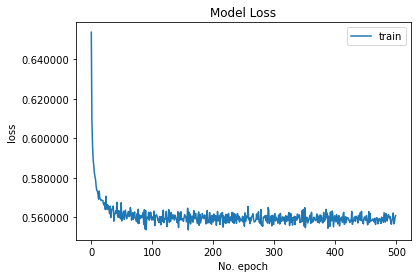

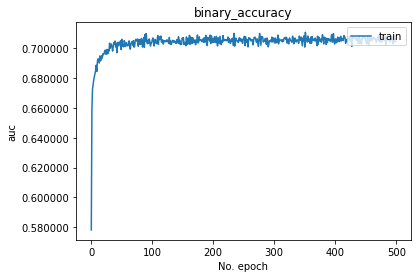

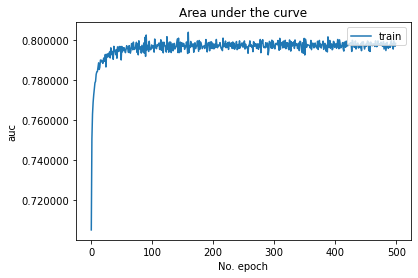

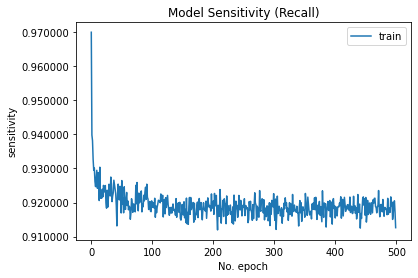

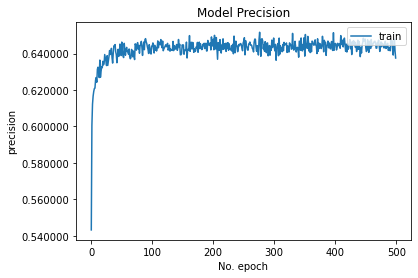

In [114]:
plt.figure(1)
plt.plot(history_baseline_2.history['loss'], label='Loss (training data)')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.6f'))
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(['train'], loc='upper right')

plt.figure(2)
acc_name = [key for key in history_baseline_2.history.keys() if "acc" in key][0]
plt.plot(history_baseline_2.history[acc_name], label='acc (training data)')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.6f'))
plt.title('binary_accuracy')
plt.ylabel('auc')
plt.xlabel('No. epoch')
plt.legend(['train'], loc='upper right')

plt.figure(3)
auc_name = [key for key in history_baseline_2.history.keys() if "auc" in key][0]
plt.plot(history_baseline_2.history[auc_name], label='auc (training data)')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.6f'))
plt.title('Area under the curve')

plt.ylabel('auc')
plt.xlabel('No. epoch')
plt.legend(['train'], loc='upper right')

plt.figure(4)
recall_name = [key for key in history_baseline_2.history.keys() if "recall" in key][0]
plt.plot(history_baseline_2.history[recall_name], label='Accuracy (training data)')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.6f'))
plt.title('Model Sensitivity (Recall)')
plt.ylabel('sensitivity')
plt.xlabel('No. epoch')
plt.legend(['train'], loc='upper right')

plt.figure(5)
recall_name = [key for key in history_baseline_2.history.keys() if "precision" in key][0]
plt.plot(history_baseline_2.history[recall_name], label='Precision (training data)')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.6f'))
plt.title('Model Precision')
plt.ylabel('precision')
plt.xlabel('No. epoch')
plt.legend(['train'], loc='upper right')

#### Evaluate

In [118]:
tf.compat.v1.random.set_random_seed(111)
test = model2.evaluate(testdata, test_labels, batch_size=1)

770/770 [==============================] - 0s 497us/sample - loss: 0.6858 - binary_accuracy: 0.6299 - precision_16: 0.4559 - recall_16: 0.8930 - auc_16: 0.7735


# Note

When Accuracy from predict() and evaluate() does not match:


[Source](https://stackoverflow.com/questions/45799474/keras-model-evaluate-vs-model-predict-accuracy-difference-in-multi-class-nlp-ta):
> I have found the problem. metrics=['accuracy'] calculates accuracy automatically from cost function. So using binary_crossentropy shows binary accuracy, not categorical accuracy. Using categorical_crossentropy automatically switches to categorical accuracy and now it is the same as calculated manually using model1.predict(). Yu-Yang was right to point out the cost function and activation function for multi-class problem.

> P.S: One can get both categorical and binary accuracy by using metrics=['binary_accuracy', 'categorical_accuracy']
